In [1]:
# Parameters
artificial_humans = {
    'all': {
        'contribution_model': "../../artifacts/artificial_humans/03_dataset/model/dataset_all.pt",
        'valid_model': "../../artifacts/artificial_humans/02_2_valid/model/rnn_True.pt"
    },
    'human_mangaged': {
        'contribution_model': "../../artifacts/artificial_humans/03_dataset/model/dataset_human_manager.pt",
        'valid_model': "../../artifacts/artificial_humans/02_2_valid/model/rnn_True.pt"
    },
}
managers = {
    "humanlike": {
        "type": "human",
        "path": "../../artifacts/human_like_manager/04_features/model/prev_punishments_True__prev_manager_valid_True__round_n_False.pt",
    },
    "optimal": {
        "type": "rl",
        "path": "../../artifacts/manager_v3/19_rerun/model/model.pt",
    },
}
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 16
n_episodes = 100


In [2]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment_v3 import ArtificialHumanEnv

from aimanager.manager.api_manager import MultiManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

output_path = os.path.join(output_path, 'data')

plot_folder = f'plots/simulate_mixed'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def mem_to_df(recorder, name):
    columns = ['episode','round_number','participant_code']

    punishments = using_multiindex(recorder.memory['punishments'].numpy(), columns=columns, value_name='punishment')
    common_good = using_multiindex(recorder.memory['common_good'].numpy(), columns=columns, value_name='common_good')
    contributions = using_multiindex(recorder.memory['contributions'].numpy(), columns=columns, value_name='contribution')

    df_sim = punishments.merge(common_good).merge(contributions)

    df_sim['participant_code'] = df_sim['participant_code'].astype(str) + '_' + df_sim['episode'].astype(str)

    df_sim['run'] = name
    return df_sim

def make_round(contributions, groups, round):
    return {
        'contributions': contributions,
        'missing_inputs': [c is None for c in contributions],
        'manager_missing_inputs': [True] * len(contributions),
        'punishments': [None] * len(contributions),
        'groups': groups,
        'round': round,
    }

def add_punishments(round, punishments):
    return {
        **round,
        'punishments': punishments,
        'manager_missing_inputs': [p is None for p in punishments],
    }


In [4]:
device = th.device('cpu')
rec_device = th.device('cpu')
mm = MultiManager(managers)

runs = {
    f"ah {h} managed by {m}": {'groups': [m]*4, 'humans': h}
    for m in managers.keys()
    for h in artificial_humans.keys()
}

dfs = []
for name, run in runs.items():
    print(f'Start run {name}')
    groups = run['groups']
    n_agents = len(groups)
    ah = GraphNetwork.load(artificial_humans[run['humans']]['contribution_model'], device=device)
    ah_val = GraphNetwork.load(artificial_humans[run['humans']]['valid_model'], device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah, 
        artifical_humans_valid=ah_val, 
        n_agents=n_agents, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=1, device=device)
    recorder = Memory(
        n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=None, device=device)
    for e in range(n_episodes):
        state = env.reset()
        rounds = []
        for round_number in count():
            contributions = state['contributions'].squeeze().tolist()
            round = make_round(contributions, groups, round_number)
            punishments = mm.get_punishments(rounds+[round])[0]
            round = add_punishments(round, punishments)
            rounds.append(round)
            punishments = th.tensor(punishments, dtype=th.int64)
            state = env.punish(punishments.unsqueeze(-1))
            recorder.add(
                **{k: v.squeeze(-1) for k, v in state.items()}, 
                episode_step=round_number)
            state, reward, done = env.step()
            if done:
                break
        recorder.next_episode(e)
    dfs.append(mem_to_df(recorder, name=name))
   

Start run ah all managed by humanlike
Start run ah human_mangaged managed by humanlike
Start run ah all managed by optimal
Start run ah human_mangaged managed by optimal


In [5]:
data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"

df_pilot = pd.read_csv(data_file)

experiment_name_map = {
    'trail_rounds_2': 'pilot human manager',
    'random_1': 'pilot rule based manager'
}

df_pilot['run'] = df_pilot['experiment_name'].map(experiment_name_map)
df_pilot['common_good'] = df_pilot['common_good'] / 4
df_pilot = df_pilot[['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'run']]

df = pd.concat([*dfs, df_pilot]).reset_index(drop=True)

dfm = df.melt(
    id_vars=['round_number', 'participant_code', 'run'], 
    value_vars=['punishment', 'contribution', 'common_good'])

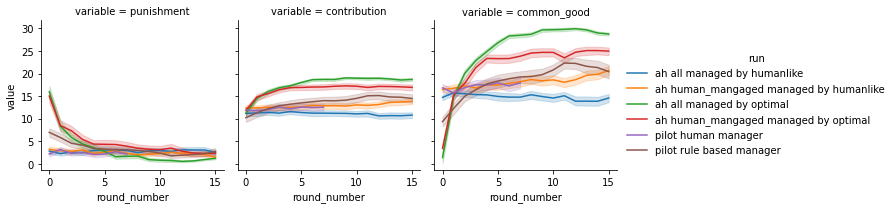

In [6]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot.jpg'))

In [9]:
dfm['run'].unique()

array(['ah all managed by humanlike',
       'ah human_mangaged managed by humanlike',
       'ah all managed by optimal',
       'ah human_mangaged managed by optimal', 'pilot human manager',
       'pilot rule based manager'], dtype=object)

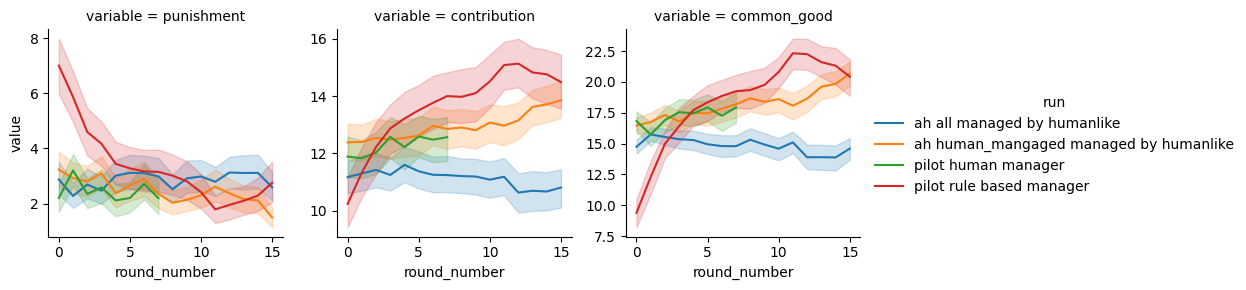

In [12]:
w = dfm['run'].isin([
    'ah all managed by humanlike',
    'ah human_mangaged managed by humanlike',
    # 'ah all managed by optimal',
    # 'ah human_mangaged managed by optimal', 
    'pilot human manager',
    'pilot rule based manager'
])

g = sns.relplot(
    data=dfm[w],
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_ah.jpg'))

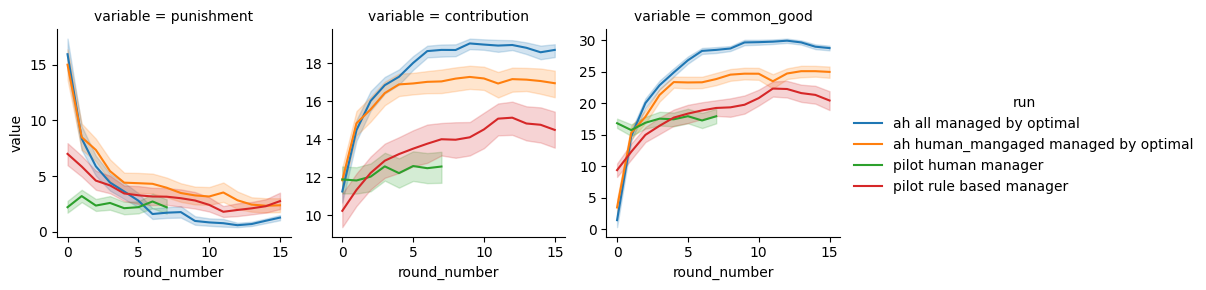

In [13]:

w = dfm['run'].isin([
    # 'ah all managed by humanlike',
    # 'ah human_mangaged managed by humanlike',
    'ah all managed by optimal',
    'ah human_mangaged managed by optimal', 
    'pilot human manager',
    'pilot rule based manager'
])

g = sns.relplot(
    data=dfm[w],
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_om.jpg'))

(0.2865363563137587, 0.7745641674339119, 613.0)


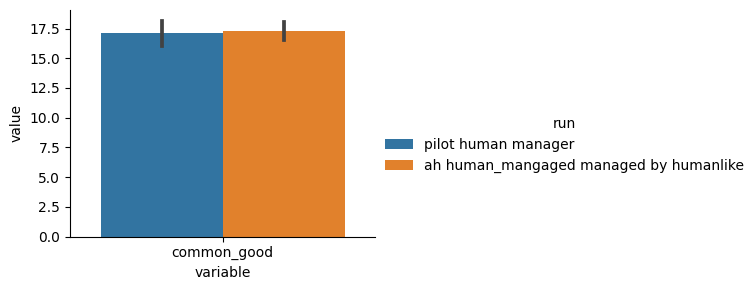

In [7]:
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

w = (
    (dfm['round_number'] < 8) &
    (dfm['variable'] == 'common_good') &
    (dfm['run'].isin(['ah human_mangaged managed by humanlike', 'pilot human manager']))
)

dfg = dfm[w].groupby(['participant_code', 'run', 'variable'])["value"].mean().reset_index()

x1 = dfg.loc[dfg['run'] == 'ah human_mangaged managed by humanlike', 'value']
x2 = dfg.loc[dfg['run'] == 'pilot human manager', 'value']

print(ttest_ind(x1, x2))


g = sns.catplot(
    data=dfg,
    x="variable", 
    y="value",
    hue='run',
    kind="bar",
    height=3, aspect=1.5, 
)

# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

g.savefig(os.path.join(plot_folder, 'comparison_pilot_bar.jpg'))


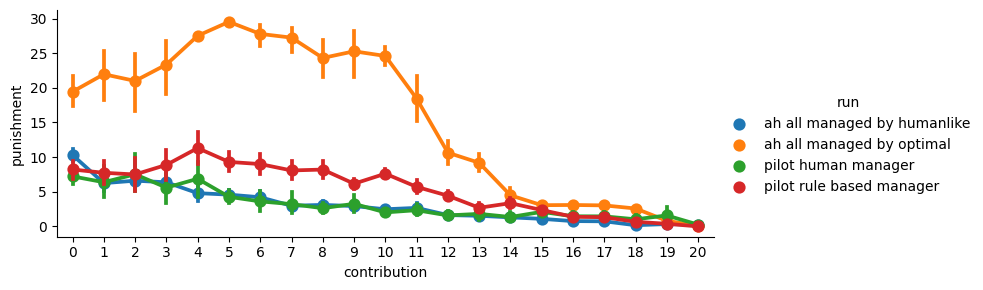

In [14]:
df['contribution'] = df['contribution'].astype(int)


w = df['run'].isin([
    'ah all managed by humanlike',
    'ah all managed by optimal',
    'pilot human manager',
    'pilot rule based manager'
])


g = sns.catplot(
    data=df[w],
    x="contribution", 
    y="punishment",
    hue='run',
    kind="point",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy.jpg'))

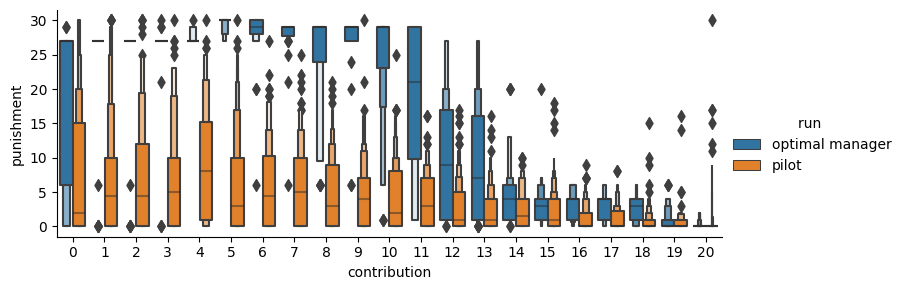

In [17]:
df['contribution'] = df['contribution'].astype(int)

df['run '] = df['run']
df['run '] = df['run'].map({
    'pilot human manager': 'pilot',
    'pilot rule based manager': 'pilot',
    'ah all managed by optimal': 'optimal manager'
})

# w = df['run'].isin([
#     'ah all managed by optimal',
#     'pilot human manager',
#     'pilot rule based manager'
# ])

g = sns.catplot(
    data=df[w],
    x="contribution", 
    y="punishment",
    hue='run ',
    kind="boxen",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy_box.jpg'))